# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
!pip install lightgbm
!pip install xgboost 

    100% |████████████████████████████████| 1.2MB 8.1MB/s eta 0:00:01    74% |███████████████████████▊        | 921kB 12.5MB/s eta 0:00:01
    100% |████████████████████████████████| 142.8MB 206kB/s eta 0:00:01 3% |█▎                              | 5.7MB 29.7MB/s eta 0:00:05    5% |██                              | 8.4MB 33.2MB/s eta 0:00:05    7% |██▌                             | 11.1MB 29.1MB/s eta 0:00:05    8% |██▉                             | 12.5MB 35.0MB/s eta 0:00:04    9% |███▏                            | 14.0MB 31.4MB/s eta 0:00:05    10% |███▌                            | 15.4MB 29.7MB/s eta 0:00:05    12% |████                            | 18.1MB 25.8MB/s eta 0:00:05    16% |█████▎                          | 23.4MB 19.4MB/s eta 0:00:07    20% |██████▍                         | 28.7MB 24.8MB/s eta 0:00:05    23% |███████▌                        | 33.7MB 25.9MB/s eta 0:00:05    24% |███████▉                        | 34.9MB 26.4MB/s eta 0:00:05    25% |████████             

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
import matplotlib.ticker as ticker
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from helpers import clean_data,strat_rand_sampling,find_missing_data,get_missing_columns
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [41]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [43]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [42]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,dataset
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4,Customers
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,6.0,3.0,0.0,9.0,NaN,3,1,4,Customers
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4,Customers
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4,Customers
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3,Customers


In [44]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [47]:
features_documented = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')
features_documented.set_index('Attribute', inplace=True)
features_documented.head(5)

,Unnamed: 0,Information level,Description,Additional notes
Attribute,,,,
AGER_TYP,NaN,NaN,best-ager typology,in cooperation with Kantar TNS; the informatio...
ALTERSKATEGORIE_GROB,NaN,Person,age through prename analysis,modelled on millions of first name-age-referen...
ANREDE_KZ,NaN,NaN,gender,NaN
CJT_GESAMTTYP,NaN,NaN,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
FINANZ_MINIMALIST,NaN,NaN,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [48]:
features_documented.shape

(313, 4)

In [50]:
# drop unwanted columns
customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)

In [51]:
azdias['dataset'] = 'Azdias'
customers['dataset'] = 'Customers'
df = pd.concat([azdias, customers])

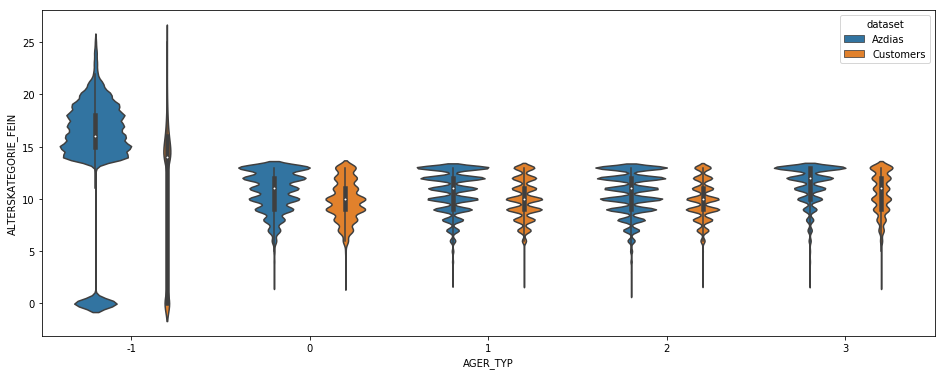

In [52]:
plt.figure(figsize=(16, 6))
sns.violinplot(x="AGER_TYP", y="ALTERSKATEGORIE_FEIN", hue="dataset", data=df, scale="count")

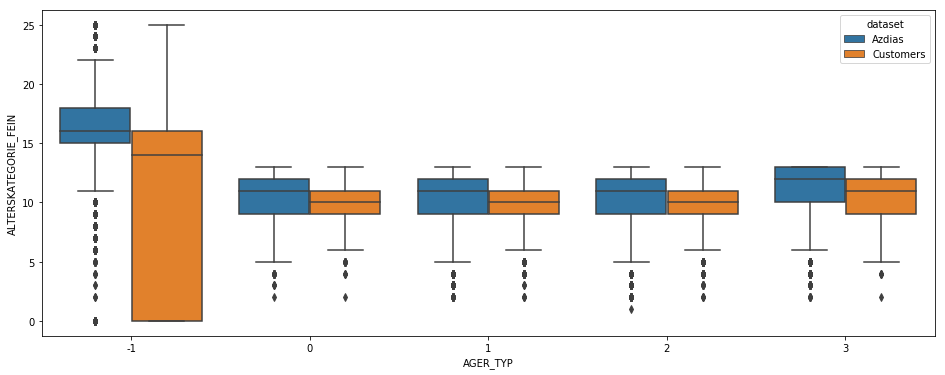

In [53]:
plt.figure(figsize=(16, 6))
sns.boxplot(x="AGER_TYP", y="ALTERSKATEGORIE_FEIN", hue="dataset", data=df)

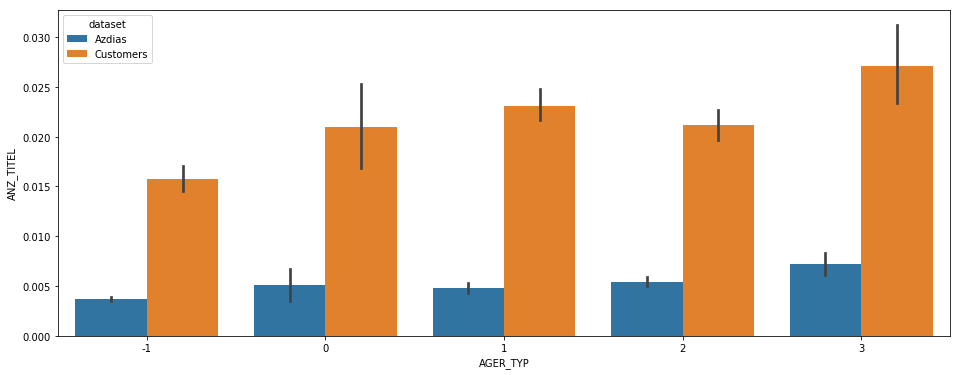

In [54]:
plt.figure(figsize=(16, 6))
sns.barplot(x="AGER_TYP", y="ANZ_TITEL", hue="dataset", data=df)

In [55]:
null_list = azdias.isnull().sum()
null_per = null_list / len(azdias) * 100

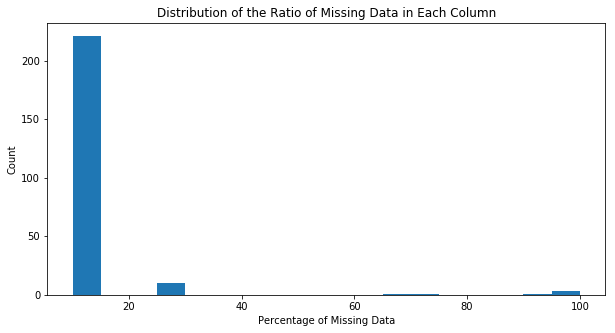

In [56]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(10,5))
plt.title('Distribution of the Ratio of Missing Data in Each Column')
plt.hist(null_per, bins = np.linspace(10,100,19))
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Count')
plt.show()

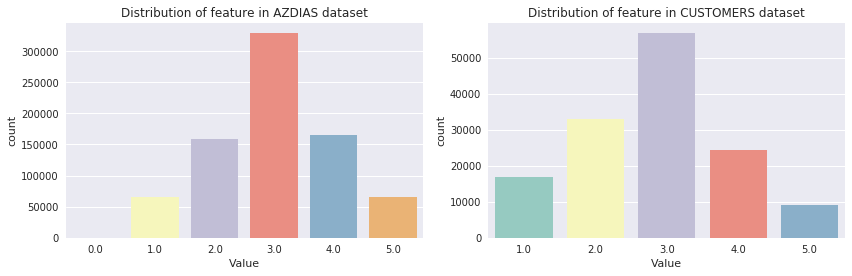

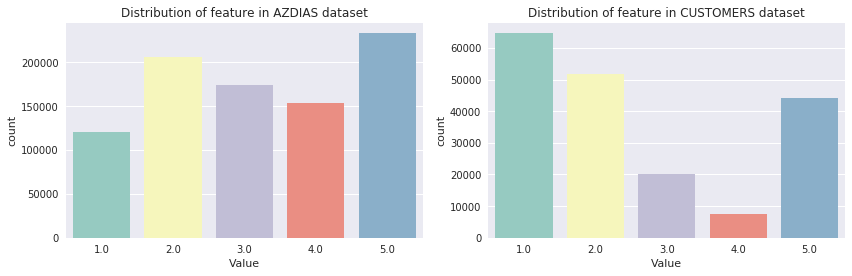

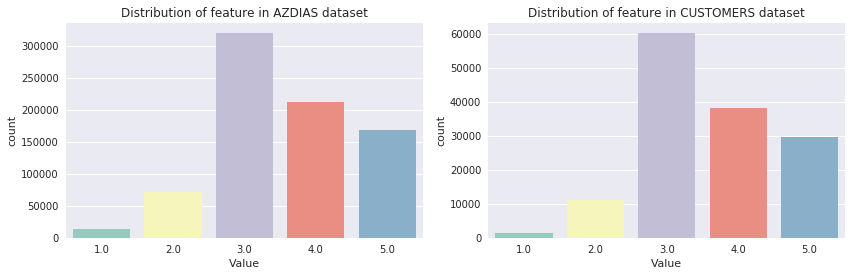

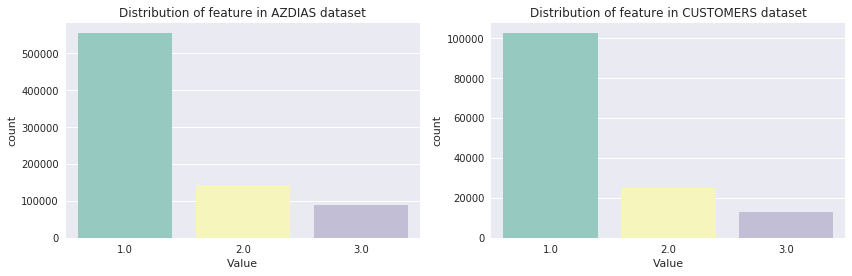

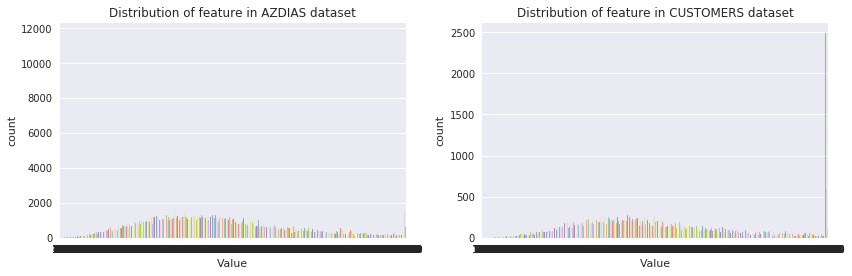

In [57]:
import random
def plot_comparison(column):
    sns.set(style="darkgrid")
    fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)
    sns.countplot(x = column, data=azdias, ax=ax1, palette="Set3")
    ax1.set_xlabel('Value')
    ax1.set_title('Distribution of feature in AZDIAS dataset')
    sns.countplot(x = column, data=customers, ax=ax2, palette="Set3")
    ax2.set_xlabel('Value')
    ax2.set_title('Distribution of feature in CUSTOMERS dataset')
    fig.tight_layout()
    plt.show()

    
for i in range(5):
    plot_comparison(azdias.columns[random.randint(0, azdias.shape[1])])

In [58]:
len_azdias, len_customers = len(azdias), len(customers)
df = pd.concat([azdias, customers])
df =azdias

In [59]:
pd.options.display.max_rows = 4000

null_list = azdias.isnull().sum()
null_per = null_list / len(azdias) * 100
null_columns = null_per[null_per > 0]

In [60]:
# Number of columns with missing data
print(len(null_columns))

273


In [61]:
# for val in null_per:
#     print(val.label)
null_columns.sort_values(ascending=False).index[:50]

Index(['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'EXTSEL992',
       'KK_KUNDENTYP', 'ALTERSKATEGORIE_FEIN', 'D19_SOZIALES',
       'D19_VERSI_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_LOTTO',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_KONSUMTYP',
       'D19_GESAMT_ONLINE_QUOTE_12', 'KBA05_MAXVORB', 'KBA05_MAXSEG',
       'KBA05_KW2', 'KBA05_MAXHERST', 'KBA05_MAXBJ', 'KBA05_MOD1', 'KBA05_KW3',
       'KBA05_KW1', 'KBA05_KRSZUL', 'KBA05_KRSVAN', 'KBA05_KRSOBER',
       'KBA05_KRSKLEIN', 'KBA05_KRSHERST3', 'KBA05_MAXAH', 'KBA05_MOD8',
       'KBA05_MOD2', 'KBA05_MOD3', 'KBA05_ZUL4', 'KBA05_ZUL3', 'KBA05_ZUL2',
       'KBA05_ZUL1', 'KBA05_VORB2', 'KBA05_VORB1', 'KBA05_VORB0', 'KBA05_SEG9',
       'KBA05_SEG8', 'KBA05_SEG7', 'KBA05_SEG6', 'KBA05_SEG5', 'KBA05_SEG4',
       'KBA05_SEG3', 'KBA05_SEG2', 'KBA05_SEG10', 'KBA05_SEG1'],
      dtype='object')

In [62]:
# Define function to plot features with missing data in a dataframe
def plot_feat(data):
    '''
    visualization: (bar plot), of top 50 features with missing data
    :data - (dataframe), dataframe to check for missing values in its columns
    
    '''
    plt.figure(figsize=(20,8))
    plt.bar(data.sort_values(ascending=False).index[:50],data.sort_values(ascending=False)[:50]);
    plt.xticks(rotation=90)
    plt.xlabel('Column name with missing values', fontsize=18,color='teal')
    plt.ylabel('Percent of missing values(%)', fontsize=18,color='teal')
    plt.show()

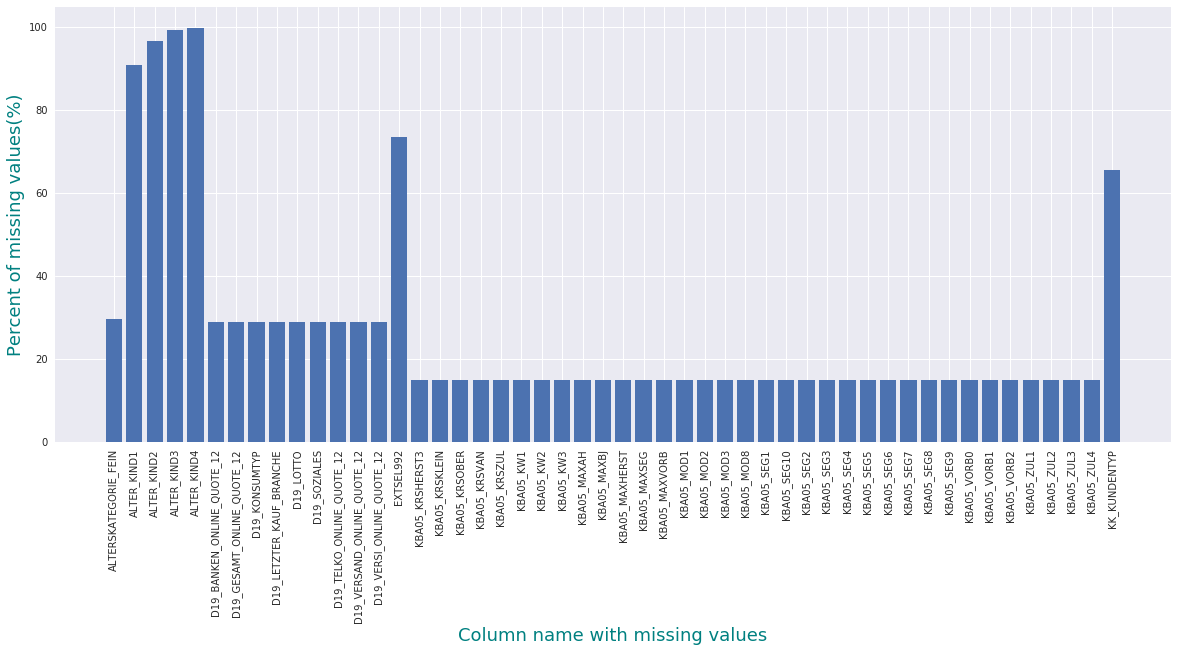

In [63]:
plot_feat(null_columns)

In [64]:
data_types = pd.read_csv('data_types.csv')
data_types.set_index('attribute', inplace=True)

In [65]:
# # Parsing missing_or_unknown column having string values to array of lists and storing it in new columnn nan_vals.
data_types['nan_vals'] = data_types['missing_or_unknown'].str.replace('[','').str.replace(']','').str.split(',').values

In [66]:
# Converting (list of string) values to (list of integers and string) in nan_vals column.
def text_to_int(value):
    try:
        int(value)
        return True
    except ValueError:    
        return False

In [67]:
data_types['nan_vals'] = data_types.apply(lambda x: [int(i) if text_to_int(i) else i for i in x['nan_vals']], axis=1)

In [68]:
# Define function to find missing values in the features
def find_missing_data(df):
    '''
    INPUT:
        df - (dataframe), dataframe to check for missing values in its columns
    OUTPUT:
        df_null: (dataframe), with count & percentage of missing values in input dataframe columns
    '''
    null_data = df.isnull().sum()[df.isnull().sum() > 0]
    
    data_dict = {'count': null_data.values, 'pct': np.round(null_data.values *100/df.shape[0],2)}
    
    df_null = pd.DataFrame(data=data_dict, index=null_data.index)
    df_null.sort_values(by='count', ascending=False, inplace=True)
    return df_null

In [71]:
df_after_nan = find_missing_data(azdias)
df_after_nan

,count,pct
ALTER_KIND4,890016,99.86
ALTER_KIND3,885051,99.31
ALTER_KIND2,861722,96.69
ALTER_KIND1,810163,90.90
EXTSEL992,654153,73.40
KK_KUNDENTYP,584612,65.60
ALTERSKATEGORIE_FEIN,262947,29.50
D19_SOZIALES,257113,28.85
D19_LOTTO,257113,28.85
D19_BANKEN_ONLINE_QUOTE_12,257113,28.85


In [72]:
np.sum(df_after_nan['count'])

33492923

In [73]:
def plot_hist_missing_col(df):
    '''
    INPUT:
        df - (dataframe), dataframe to check for missing data and plot histogram of the missing data in columns
    OUTPUT:
        visualization: (histogram), of the missing data
    '''
    plt.hist(df['pct'], bins=20, facecolor='g', alpha=0.75)

    plt.xlabel('Percentage of missing value (%)', fontsize=12)
    plt.ylabel('Counts', fontsize=12)
    plt.title('Histogram of missing value counts in columns', fontsize=12)
    plt.grid(True)
    plt.show()

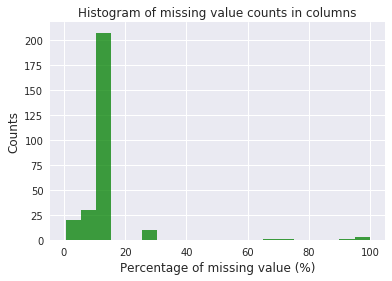

In [74]:
plot_hist_missing_col(df_after_nan)

In [75]:
# Define function to plot top 50 features with missing data in a dataframe
def plot_top50_feat(df):
    '''
    INPUT:
        df - (dataframe), dataframe to check for missing values in its columns & plot top 50 features with misisng data
    OUTPUT:
        visualization: (bar plot), of top 50 features with missing data
    '''
    np.round((df.isnull().sum().sort_values(ascending=False)*100/df.shape[0]),2)[:50].plot.bar(figsize=(20,8),\
                                                                                               fontsize=12,color='teal');
    plt.xlabel('Column name with missing values', fontsize=18)
    plt.ylabel('Percent of missing values(%)', fontsize=18)
    plt.show()

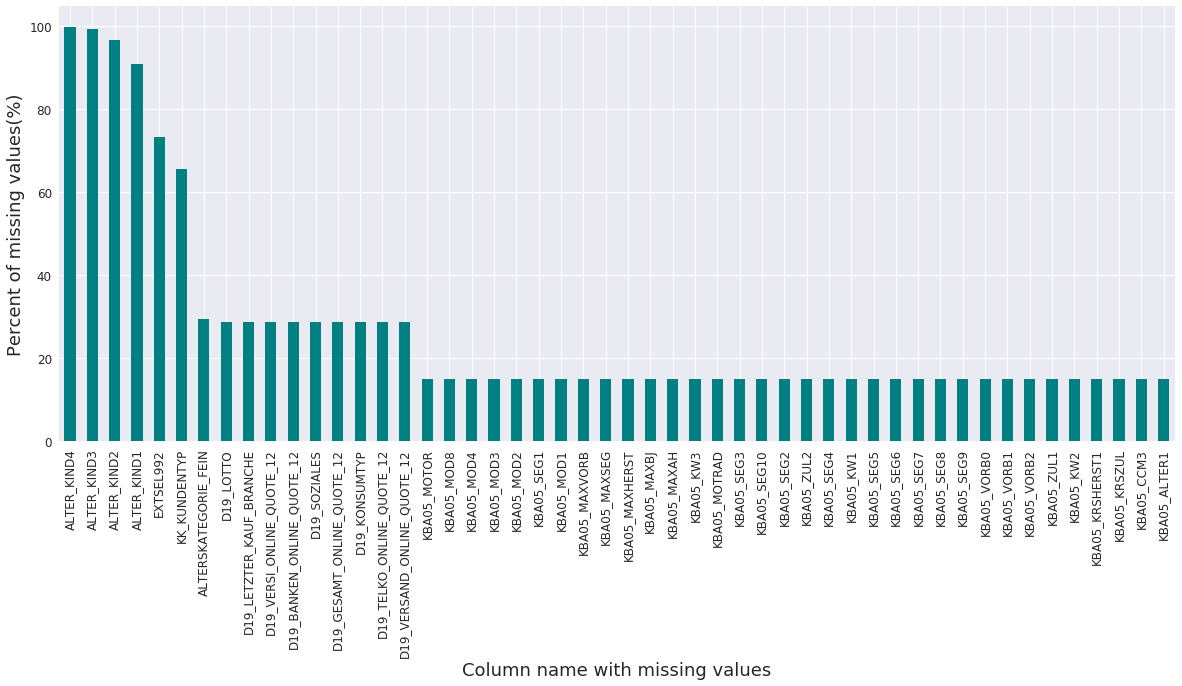

In [76]:
# Visualizing the top 50 features with missing data(after encoding) in the azdias dataset.
plot_top50_feat(df)

In [77]:
def find_cols_with_missing_data(df, pct):
    '''
    :param
    df - (dataframe): dataframe to check for missing values in its columns
     
    :return (list)- list of columns with more than pct missing values
    '''
    missing_pct_cols = [col for col in df.columns if (df[col].isnull().sum()/df.shape[0]) * 100 > pct]
    return missing_pct_cols

In [78]:
missing_data_columns = find_cols_with_missing_data(azdias, pct=20)
missing_data_columns.append('LNR')

In [79]:
df_null_data_row_few = df[df.isnull().sum(axis=1) < 9]

In [80]:
# Zooming in the histogram and ploting the distribution of rows with atleast 8% missing data.
df_null_data_row_high = df[df.isnull().sum(axis=1) >= 9]

In [81]:
data_types=get_missing_columns()
attr_not_in_feat_info = np.setdiff1d(np.array(df.columns), np.array(data_types.index), assume_unique=True)
print(len(attr_not_in_feat_info))

54


In [82]:
attr_not_in_feat_info

array(['LNR', 'AKT_DAT_KL', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'ANZ_KINDER',
       'ANZ_STATISTISCHE_HAUSHALTE', 'CJT_KATALOGNUTZER', 'CJT_TYP_1',
       'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6',
       'D19_KONSUMTYP_MAX', 'D19_LETZTER_KAUF_BRANCHE', 'D19_SOZIALES',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12',
       'DSL_FLAG', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'EXTSEL992',
       'FIRMENDICHTE', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KBA13_ANTG1',
       'KBA13_ANTG2', 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_BAUMAX',
       'KBA13_CCM_1401_2500', 'KBA13_GBZ', 'KBA13_HHZ', 'KBA13_KMH_210',
       'KOMBIALTER', 'KONSUMZELLE', 'MOBI_RASTER', 'RT_KEIN_ANREIZ',
       'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE', 'STRUKTURTYP', 'UMFELD_ALT',
       'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM', 'VHA', 'VHN',
       'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'dataset'], dtype=object)

In [83]:
# Drop rows with high missing values in the azdias dataset.
print('Total number of rows : {}'.format(df.shape[0]))

df = df[df.index.isin(df_null_data_row_few.index)]

print('Number of rows after dropping rows with more than 8 missing values : {}'.format(df.shape[0]))

Total number of rows : 891221
Number of rows after dropping rows with more than 8 missing values : 564304


In [47]:
np.round(df[attr_not_in_feat_info.tolist()].isnull().sum().sort_values(ascending=False)/df[attr_not_in_feat_info.tolist()].shape[0],2)

ALTER_KIND4                   1.00
ALTER_KIND3                   0.99
ALTER_KIND2                   0.96
ALTER_KIND1                   0.89
EXTSEL992                     0.62
ALTERSKATEGORIE_FEIN          0.13
HH_DELTA_FLAG                 0.03
VHN                           0.01
UMFELD_JUNG                   0.00
UMFELD_ALT                    0.00
RT_UEBERGROESSE               0.00
GEMEINDETYP                   0.00
STRUKTURTYP                   0.00
VERDICHTUNGSRAUM              0.00
KONSUMZELLE                   0.00
FIRMENDICHTE                  0.00
CJT_TYP_5                     0.00
D19_LETZTER_KAUF_BRANCHE      0.00
D19_SOZIALES                  0.00
D19_KONSUMTYP_MAX             0.00
CJT_TYP_6                     0.00
ANZ_KINDER                    0.00
CJT_TYP_4                     0.00
CJT_TYP_3                     0.00
CJT_TYP_2                     0.00
CJT_TYP_1                     0.00
CJT_KATALOGNUTZER             0.00
ANZ_STATISTISCHE_HAUSHALTE    0.00
D19_VERSI_ONLINE_QUO

In [84]:
columns_to_drop = attr_not_in_feat_info.tolist()
# columns_to_drop.remove("dataset")

In [85]:
df.drop(columns_to_drop, axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [86]:
df.shape

(564304, 313)

In [87]:
# Find number of attributes which are in df but not in feat_info
attr_not_in_feat_info = np.setdiff1d(np.array(df.columns), np.array(data_types.index), assume_unique=True)
print(len(attr_not_in_feat_info))

0


In [7]:
# Creating decade_dict and decade_list to be used in make_decade function.
decade_dict = {1: [1, 2], 2: [3, 4], 3: [5, 6, 7], 4: [8, 9], 5: [10, 11, 12, 13], 6:[14, 15]}
decade_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

        

# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
def make_decade(x):
    
    if pd.isnull(x):
        return np.nan
    else:
        for key, array in decade_dict.items():
            if x in array:
                return key
            elif x not in decade_list:
                print('There is some error while mapping decade. Please check.')

    
def make_movement(x):
    if pd.isnull(x):
        return np.nan
    elif x in (2,4,6,7,9,11,13,15):
        return 0        
    elif x in (1,3,5,8,10,12,14):
        return 1
    else:
        print('There is some error while mapping movement. Please check.')

In [8]:

# Investigate "CAMEO_INTL_2015" and engineer two new variables.
def make_wealth(x):
#    print(x)
#    print(type(x))
    if pd.isnull(x):
        return np.nan 
    elif int(x) // 10 == 1:
        return 1
    elif int(x) // 10 == 2:
        return 2
    elif int(x) // 10 == 3:
        return 3
    elif int(x) // 10 == 4:
        return 4
    elif int(x) // 10 == 5:
        return 5
    
def make_life_stage(x):
    if pd.isnull(x):
        return np.nan 
    elif int(x) % 10 == 1:
        return 1
    elif int(x) % 10 == 2:
        return 2
    elif int(x) % 10 == 3:
        return 3
    elif int(x) % 10 == 4:
        return 4
    elif int(x) % 10 == 5:
        return 5

In [9]:
def clean_my_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    for idx in data_types.index:
        column = idx
        if column in df.columns:
            df[column] = df[column].replace(data_types.loc[column]['nan_vals'], np.nan)

      
    # remove selected columns
    df.drop(['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',\
             'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE',\
             'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12',\
             'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992','GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ', 'LNR'],
            axis=1, inplace=True)
    
    
    # remove selected rows
    df = df[df.isnull().sum(axis=1) < 9].reset_index(drop=True)
    
    # remove selected columns again
    features_not_in_feat_info_42 = ['AKT_DAT_KL', 'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE', 'CJT_KATALOGNUTZER','CJT_TYP_1',\
                                    'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'DSL_FLAG',\
                                    'EINGEZOGENAM_HH_JAHR','FIRMENDICHTE', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KBA13_ANTG1',\
                                    'KBA13_ANTG2', 'KBA13_ANTG3','KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_CCM_1401_2500',\
                                    'KBA13_GBZ', 'KBA13_HHZ', 'KBA13_KMH_210','KONSUMZELLE', 'MOBI_RASTER', 'RT_KEIN_ANREIZ',\
                                    'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE', 'STRUKTURTYP','UMFELD_ALT', 'UMFELD_JUNG',\
                                    'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM', 'VHA', 'VHN', 'VK_DHT4A','VK_DISTANZ',\
                                    'VK_ZG11','D19_KONSUMTYP_MAX', 'KOMBIALTER','EINGEFUEGT_AM']
    
    df.drop(features_not_in_feat_info_42,axis=1, inplace=True)

    
    # select, re-encode, and engineer column values.
    # # feature engineering of categorical features

    df['OST_WEST_KZ'].replace(['W','O'], [1, 0], inplace=True)
    
    multi = ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CJT_GESAMTTYP', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',\
             'D19_BANKEN_DATUM','D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_GESAMT_ANZ_12',\
             'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM','D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',\
             'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM','D19_VERSAND_DATUM',\
             'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',\
             'D19_VERSI_ONLINE_DATUM', 'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_FAMILIE_GROB',\
             'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP']
        
    df = pd.get_dummies(df, columns=multi, prefix=multi)
    
    
     # feature engineering of mixed features
    df['PRAEGENDE_JUGENDJAHRE_decade'] = df['PRAEGENDE_JUGENDJAHRE'].apply(make_decade)
    df['PRAEGENDE_JUGENDJAHRE_movement'] = df['PRAEGENDE_JUGENDJAHRE'].apply(make_movement)
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    
    df['CAMEO_INTL_2015_wealth'] = df['CAMEO_INTL_2015'].apply(make_wealth) 
    df['CAMEO_INTL_2015_life_stage'] = df['CAMEO_INTL_2015'].apply(make_life_stage)
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    df['WOHNLAGE_rural'] = df['WOHNLAGE'].map({0:0,1:0,2:0,3:0,4:0,5:0,7:1,8:1})
    df['WOHNLAGE_rating_class'] = df['WOHNLAGE'].map({0:0,1:1,2:2,3:3,4:4,5:5,7:0,8:0})
    
    df = df.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'], axis=1)
    
    
    # Return the cleaned dataframe.
    return df

In [10]:
def strat_rand_sampling(df, frac):
    '''
    INPUT:
        df - dataframe, from which sample has to be dervied\
        frac - float, proportion of number of observations in df to be dervied in sample
    OUTPUT:
        sample_df: dataframe, dataframe sampled from df
        
    '''
    sample_df = df.sample(frac=frac, random_state=42)
        
    return sample_df


In [88]:
df=None

In [20]:
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [59]:
# azdias['CAMEO_INTL_2015'].apply(make_decade)
# azdias=df 

In [21]:
azdias_null_data_row_8 = azdias.isnull().sum(axis=1)

In [22]:
sample_df_list = [strat_rand_sampling(df=azdias[azdias_null_data_row_8 == missing_val],frac=0.20) for missing_val in range(0,9)]

In [23]:
azdias = pd.concat(sample_df_list)

In [24]:
azdias = clean_my_data(azdias)

In [25]:
azdias.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_REST,...,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage,WOHNLAGE_rural,WOHNLAGE_rating_class
0,8.0,0.0,1.0,0.0,2.0,1.0,6,5,0,0,...,0,1,0,0,6.0,1.0,4.0,1.0,0,4
1,2.0,0.0,6.0,0.0,2.0,6.0,0,0,0,7,...,0,1,0,0,5.0,0.0,1.0,2.0,1,0
2,1.0,0.0,4.0,0.0,2.0,2.0,5,0,0,0,...,0,0,0,0,6.0,0.0,3.0,5.0,0,1
3,4.0,0.0,3.0,0.0,2.0,6.0,4,6,0,0,...,0,1,0,0,6.0,1.0,2.0,3.0,1,0
4,2.0,0.0,2.0,0.0,3.0,5.0,6,0,0,0,...,0,1,0,0,6.0,1.0,4.0,3.0,0,2


In [28]:
# Impute nans with mode value
imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
azdias_sample_imputed = imputer.fit_transform(azdias)
print('Type of azdias_sample_imputed is : {}'.format(type(azdias_sample_imputed)))


Type of azdias_sample_imputed is : <class 'numpy.ndarray'>


In [29]:
# Making azdias_imputed into a dataframe
azdias_sample_imputed = pd.DataFrame(azdias_sample_imputed)
print('Type of azdias_sample_imputed now is : {}'.format(type(azdias_sample_imputed)))
# azdias_sample_imputed.head()

Type of azdias_sample_imputed now is : <class 'pandas.core.frame.DataFrame'>


In [30]:
# Apply feature scaling to the general population demographics data.

SC = StandardScaler()
azdias_sample_scaled = SC.fit_transform(azdias_sample_imputed)
print('Type of azdias_sample_scaled is : {}'.format(type(azdias_sample_scaled)))



Type of azdias_sample_scaled is : <class 'numpy.ndarray'>


In [31]:
# Making azdias_sample_scaled into a dataframe
azdias_sample_scaled = pd.DataFrame(azdias_sample_scaled, columns= list(azdias.columns.values))
print('Type of azdias_sample_scaled now is : {}'.format(type(azdias_sample_scaled)))
# azdias_sample_scaled.head()

Type of azdias_sample_scaled now is : <class 'pandas.core.frame.DataFrame'>


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [89]:
def perform_pca(data,*args, **kwargs):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    X = data
    
    if 'n_components' in kwargs:
        n_components = kwargs.get('n_components')
        pca = PCA(n_components, random_state=42)
    else:
        pca = PCA(random_state=42)
        
    X_pca = pca.fit_transform(X)
    return pca, X_pca

In [90]:
def component_variance_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.grid()
    ax.set_axisbelow(True)
    ax.grid(linewidth='0.5', alpha=0.5)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [91]:
customers = None
azdias = None

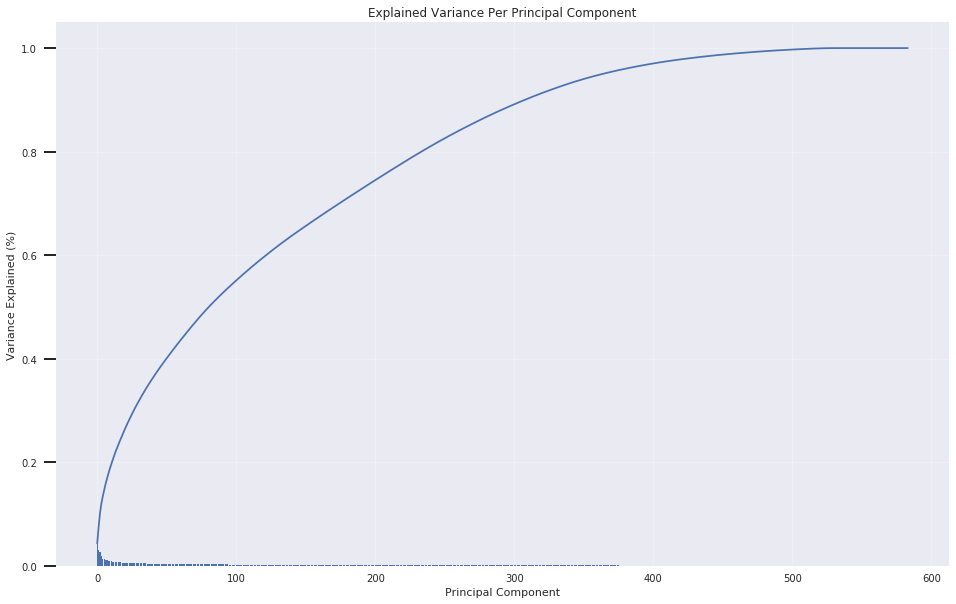

In [92]:
pca, azdias_pca = perform_pca(azdias_sample_scaled)
component_variance_plot(pca)

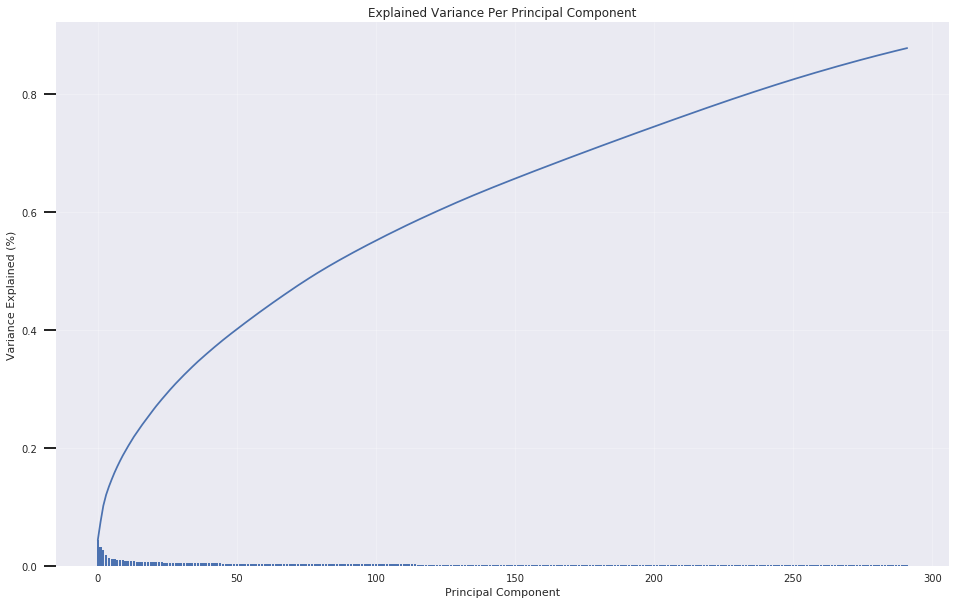

In [93]:
pca, azdias_pca = perform_pca(azdias_sample_scaled,n_components=292)
component_variance_plot(pca)

In [94]:
# Define plot function to check out the ratio of variance explained by each principal component

def plot_variance_ratio(pca):
    '''
    Creates a plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 10))
    ax = plt.subplot(111)
    #cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    #ax.plot(ind, cumvals)
    
    ax.grid()
    ax.set_axisbelow(True)
    ax.grid(linewidth='0.5', alpha=0.5)
   
    # Printing percentage of variance explained by first 5 components.
    for i in range(ind[5]):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

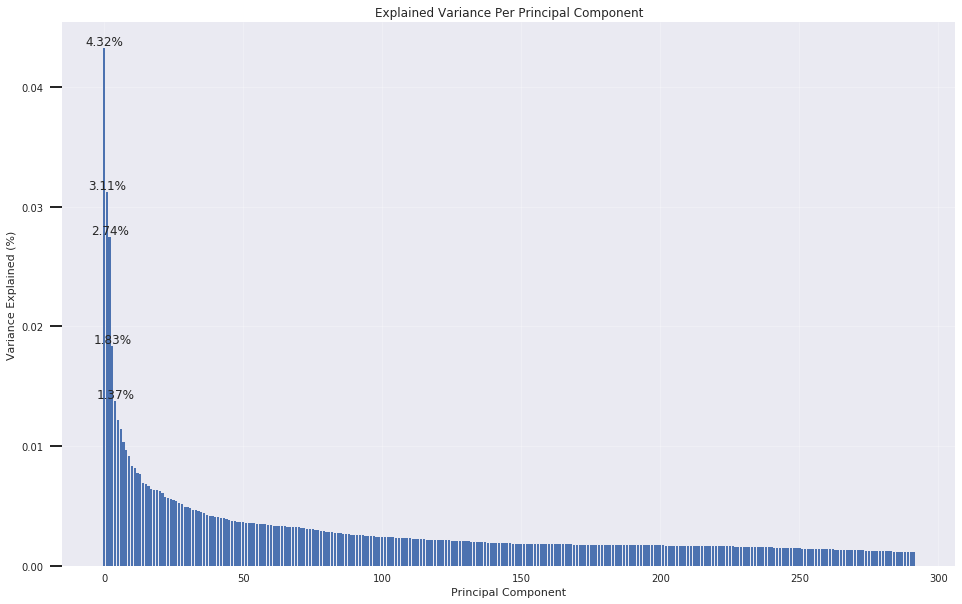

In [95]:
plot_variance_ratio(pca)

In [96]:
# Define plot function to check out cumulative variance explained by principal components.

def plot_cumulative_variance(pca):
    '''
    Creates a plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    #ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.grid()
    ax.set_axisbelow(True)
    ax.grid(linewidth='0.5', alpha=0.5)
    
    cumval_ind_hv1 = []
    cumval_ind_hv2 = []
    cumval_ind_hv3 = []
    cumval_ind_hv4 = []
    cumval_ind_hv5 = []
    cumval_ind_hv6 = []
#    cumval_ind_hv7 = []
    for i in enumerate(cumvals):
        if i[1] > 0.3 and i[1] < 0.4:
            cumval_ind_hv1.append(i)
        elif i[1] > 0.4 and i[1] < 0.5:
            cumval_ind_hv2.append(i)
        elif i[1] > 0.5 and i[1] < 0.6:
            cumval_ind_hv3.append(i)
        elif i[1] > 0.6 and i[1] < 0.7:
            cumval_ind_hv4.append(i)
        elif i[1] > 0.7 and i[1] < 0.8:
            cumval_ind_hv5.append(i)
        elif i[1] > 0.8 and i[1] < 0.9:
            cumval_ind_hv6.append(i)    
#        elif i[1] > 0.9:
#            cumval_ind_hv7.append(i)
            
    #print(cumval_ind_hv1[0][0])
    #print(cumval_ind_hv2[0][0])
    #print(cumval_ind_hv3[0][0])
    #print(cumval_ind_hv4[0][0])
    
    # Plotting horizontal and vertical at points with cumulative variance of 30%, 50%, 60% and 80%.

    plt.hlines(y=0.3, xmin=0, xmax=cumval_ind_hv1[0][0], color='red', linestyles='dashed',zorder=1)
    plt.vlines(x=cumval_ind_hv1[0][0], ymin=0, ymax=0.3, color='red', linestyles='dashed',zorder=2)
    plt.hlines(y=0.4, xmin=0, xmax=cumval_ind_hv2[0][0], color='red', linestyles='dashed',zorder=3)
    plt.vlines(x=cumval_ind_hv2[0][0], ymin=0, ymax=0.4, color='red', linestyles='dashed',zorder=4)
    plt.hlines(y=0.5, xmin=0, xmax=cumval_ind_hv3[0][0], color='red', linestyles='-',zorder=5)
    plt.vlines(x=cumval_ind_hv3[0][0], ymin=0, ymax=0.5, color='red', linestyles='-',zorder=6)
    plt.hlines(y=0.6, xmin=0, xmax=cumval_ind_hv4[0][0], color='red', linestyles='dashed',zorder=7)
    plt.vlines(x=cumval_ind_hv4[0][0], ymin=0, ymax=0.6, color='red', linestyles='dashed',zorder=8)
    plt.hlines(y=0.7, xmin=0, xmax=cumval_ind_hv5[0][0], color='red', linestyles='dashed',zorder=9)
    plt.vlines(x=cumval_ind_hv5[0][0], ymin=0, ymax=0.7, color='red', linestyles='dashed',zorder=10)
    plt.hlines(y=0.8, xmin=0, xmax=cumval_ind_hv6[0][0], color='red', linestyles='dashed',zorder=11)
    plt.vlines(x=cumval_ind_hv6[0][0], ymin=0, ymax=0.8, color='red', linestyles='dashed',zorder=12) 
#    plt.hlines(y=0.9, xmin=0, xmax=cumval_ind_hv7[0][0], color='red', linestyles='dashed',zorder=13)
#    plt.vlines(x=cumval_ind_hv7[0][0], ymin=0, ymax=0.9, color='red', linestyles='dashed',zorder=14)
    
    # Plotting number of components for cumulative variance of 30%, 50%, 60% and 80%.
    for i,v in [cumval_ind_hv1[0], cumval_ind_hv2[0], cumval_ind_hv3[0],\
                cumval_ind_hv4[0], cumval_ind_hv5[0], cumval_ind_hv6[0]]:
        ax.annotate(r"%s" % ((str(i+1))), (i+0.2, np.round(v, 2)), va="bottom", ha="center", fontsize=12)


 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Cumulative Variance of Principal Components')

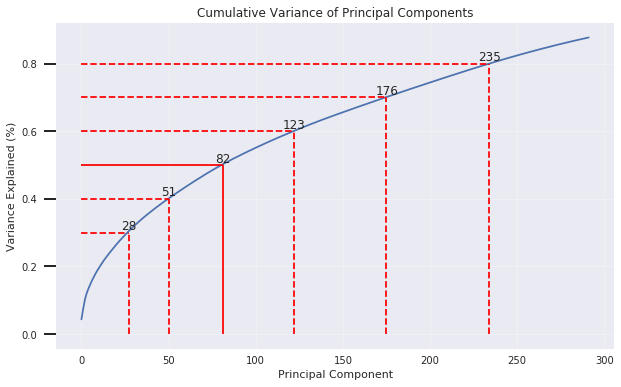

In [97]:
plot_cumulative_variance(pca)

In [98]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_82, azdias_sample_pca = perform_pca(azdias_sample_scaled,n_components=82)

In [99]:
def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = 82-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)
    
    
    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num + 1))
    plt.show()

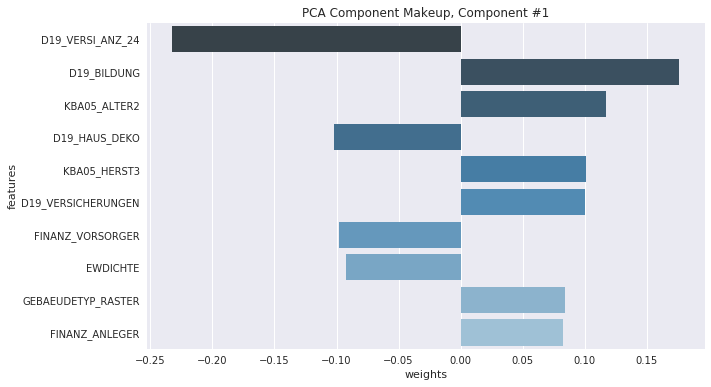

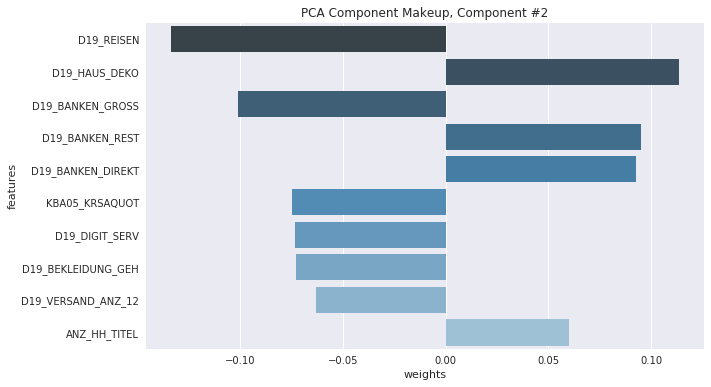

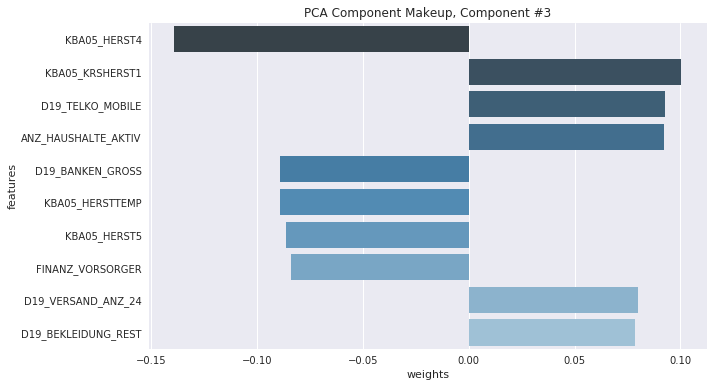

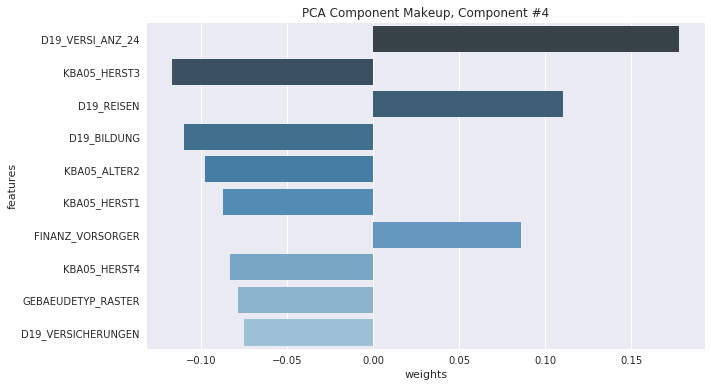

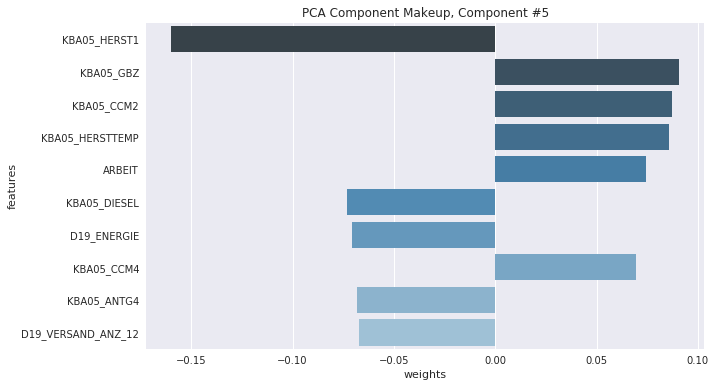

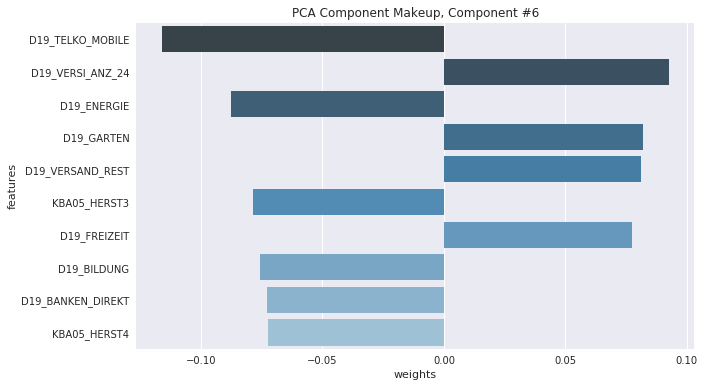

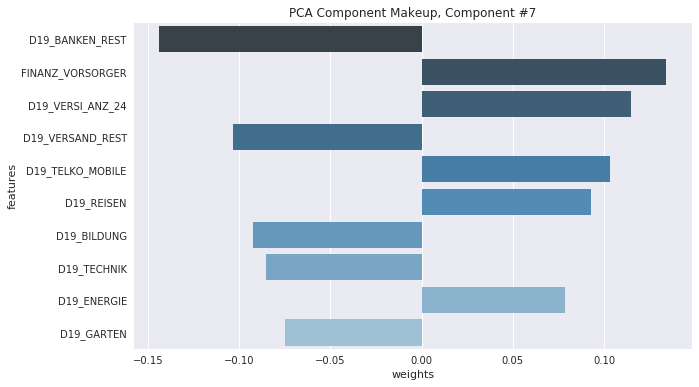

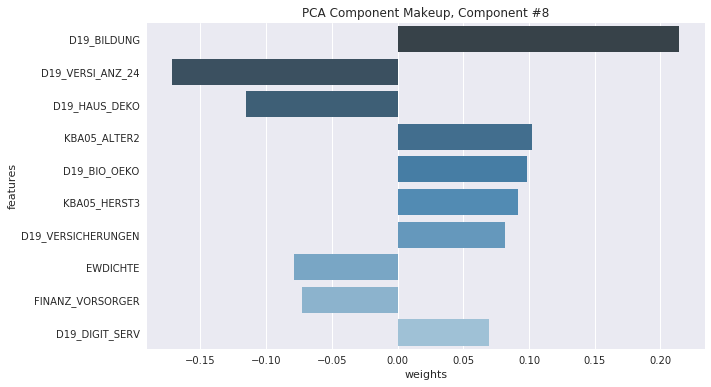

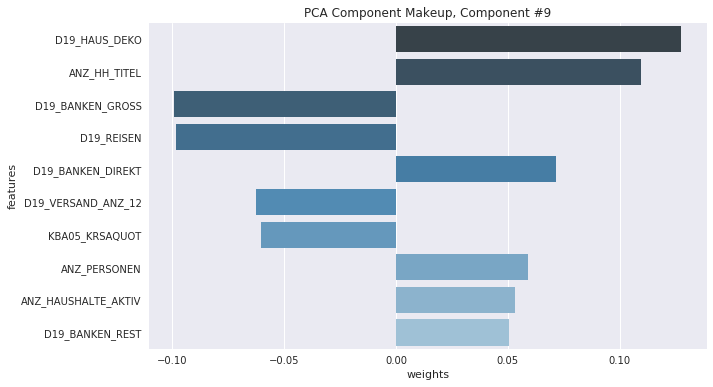

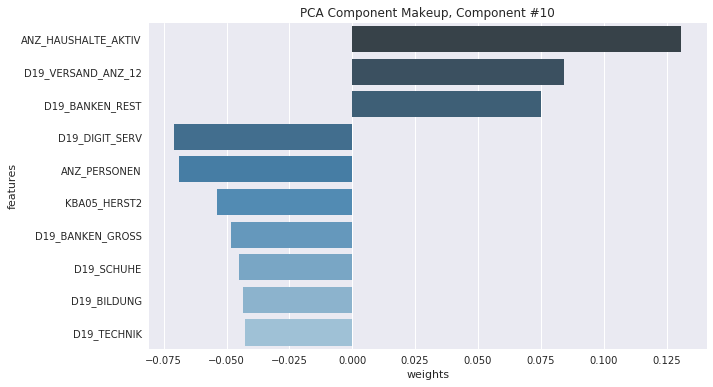

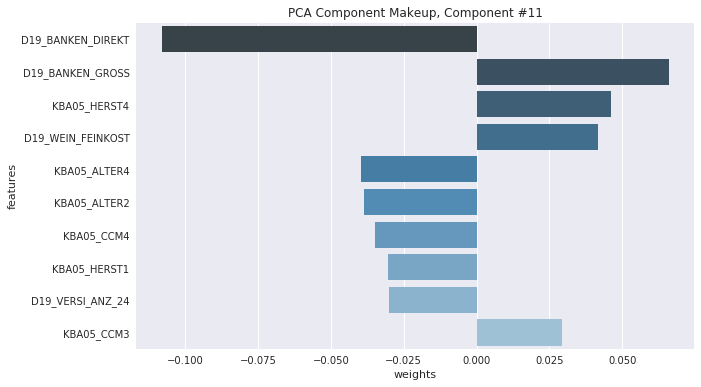

In [100]:
# display makeup of first component
for num in range(0,11):
    display_component(pd.DataFrame(pca_82.components_), azdias_sample_scaled.columns, num, n_weights=10)

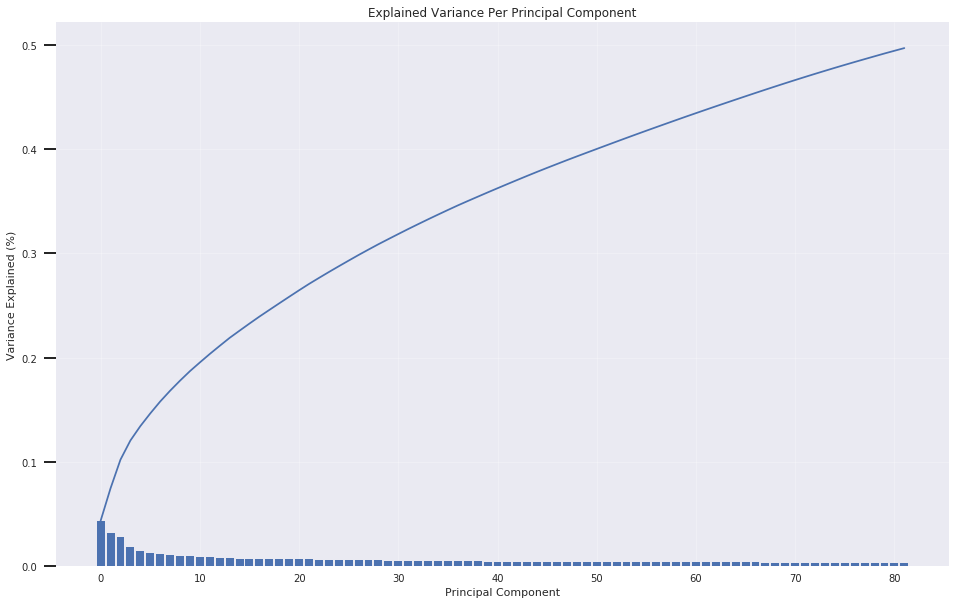

In [101]:
component_variance_plot(pca_82)

In [102]:
print(pca_82.components_)

[[-0.08094872 -0.01482675  0.08357462 ...,  0.07012798  0.07368992
  -0.094802  ]
 [ 0.0187735   0.02692521 -0.06063273 ...,  0.01418105 -0.06152112
   0.02612096]
 [ 0.04361998  0.01717875  0.0387922  ..., -0.05438346 -0.08065761
   0.06984283]
 ..., 
 [ 0.04348127  0.05925913 -0.01940188 ..., -0.04402807 -0.05441255
   0.04987789]
 [-0.05671688 -0.09889938 -0.00306926 ..., -0.03057989  0.03649859
  -0.01532585]
 [-0.00281251 -0.03723906 -0.00695144 ..., -0.01310069 -0.01428923
   0.01448348]]


In [103]:
print(pca_82.explained_variance_)

[ 25.25643034  18.2151793   16.05636587  10.73985832   8.05049582
   7.12011898   6.68631716   6.05160944   5.64702019   5.33974919
   4.87492229   4.76027589   4.55105447   4.47494051   4.03302637
   3.99505324   3.90320948   3.73114017   3.71147065   3.6746389
   3.64275124   3.55548672   3.36564475   3.3133015    3.2343781
   3.18423612   3.15269772   3.04373399   2.99383627   2.86348854
   2.83928183   2.8109936    2.73122758   2.70217194   2.64488171
   2.60768679   2.56016669   2.45218903   2.41303796   2.40263829
   2.36294757   2.34579377   2.31996619   2.29423271   2.25603521
   2.21132536   2.17130935   2.16177627   2.11087047   2.08576471
   2.07767886   2.07051289   2.06461375   2.05515225   2.02919325
   2.01559429   1.99353707   1.98133325   1.97471735   1.96250371
   1.93242982   1.92366369   1.908399     1.8889717    1.88120206
   1.86888655   1.85821752   1.84054679   1.81880878   1.80329387
   1.77374831   1.74909677   1.72805744   1.69657116   1.68120264
   1.6469607

In [104]:
print("original shape:   ", azdias_sample_scaled.shape)
print("transformed shape:", azdias_sample_pca.shape)

original shape:    (111456, 584)
transformed shape: (111456, 82)


In [105]:
dimensions = ['PC {}'.format(i) for i in range(1,len(pca_82.components_)+1)]
ratios = pca_82.explained_variance_ratio_
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['EXPLAINED_VARIANCE RATIO'])
variance_ratios.index = dimensions

In [106]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [107]:
scores = []
centers = list(range(2,26,1))

for center in centers:
    score = round(get_kmeans_score(azdias_sample_pca, center),2)
    print('center : {}     score : {}'.format(center, score))
    scores.append(score)

center : 2     score : 30323826.69
center : 3     score : 29341163.64
center : 4     score : 28634598.04
center : 5     score : 28091603.4
center : 6     score : 27691960.48
center : 7     score : 27349904.62
center : 8     score : 27075187.86
center : 9     score : 26838043.18
center : 10     score : 26597910.67
center : 11     score : 26384111.72
center : 12     score : 26204390.87
center : 13     score : 26026656.71
center : 14     score : 25907900.64
center : 15     score : 25728356.77
center : 16     score : 25507037.88
center : 17     score : 25361174.15
center : 18     score : 25225646.88
center : 19     score : 25151909.08
center : 20     score : 24946259.87
center : 21     score : 24819591.62
center : 22     score : 24663119.84
center : 23     score : 24541627.67
center : 24     score : 24459752.22
center : 25     score : 24247650.16


In [108]:
# Create dataframe showing the average point-centroid distances
scores_ds = pd.Series(scores).round(2)
centers_ds = pd.Series(centers)
average_distance = np.array(scores)/azdias_sample_pca.shape[0]
average_distance_ds = pd.Series(average_distance).round(2)

scores_df = pd.concat([centers_ds, scores_ds, average_distance_ds],axis=1)
scores_df.columns = ['clusters','score','average_distance']
scores_df.set_index('clusters',inplace=True)
scores_df

,score,average_distance
clusters,,
2,30323826.69,272.07
3,29341163.64,263.25
4,28634598.04,256.91
5,28091603.40,252.04
6,27691960.48,248.46
7,27349904.62,245.39
8,27075187.86,242.92
9,26838043.18,240.79
10,26597910.67,238.64


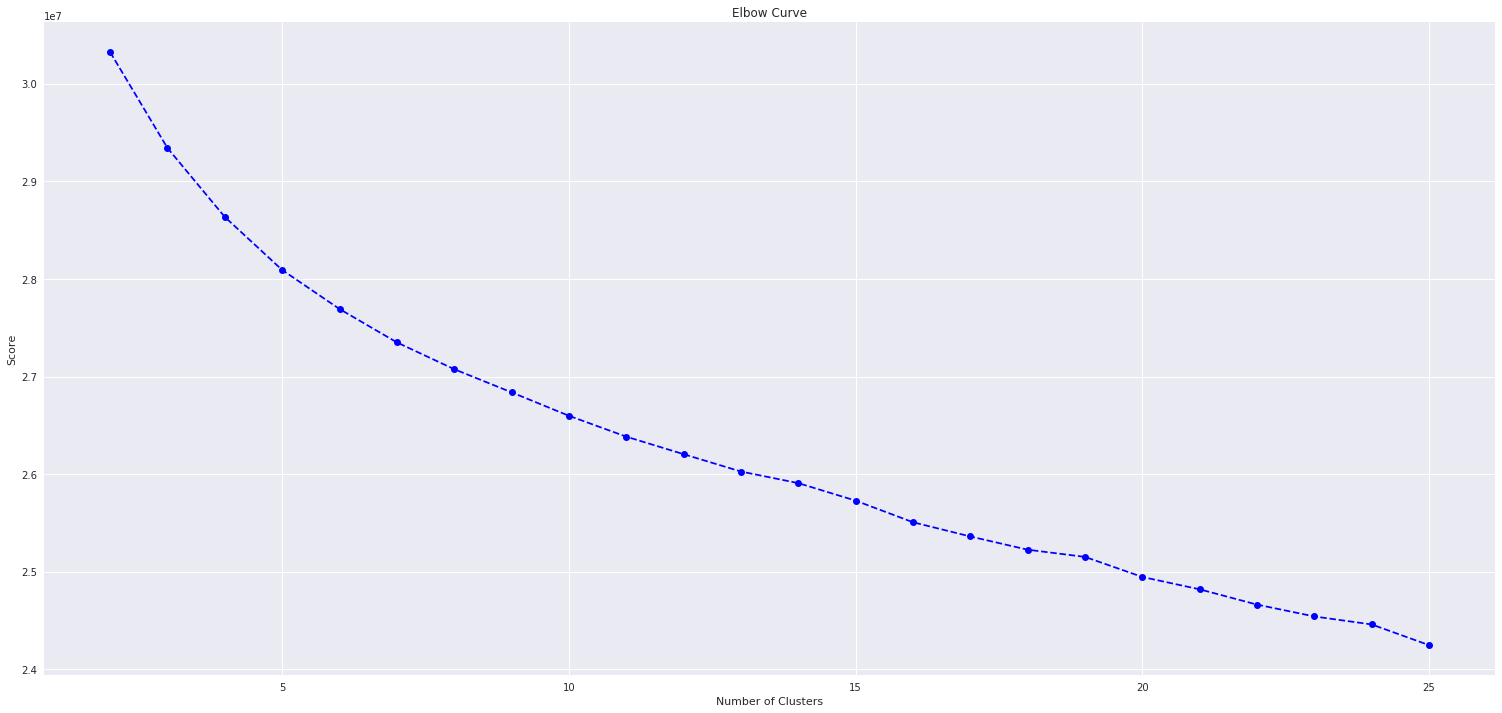

In [109]:
plt.figure(figsize=(26, 12))
plt.plot(centers,scores,linestyle='--', marker='o', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [110]:
azdias_sample_pca_df=pd.DataFrame(azdias_sample_pca)
azdias_sample_pca_df.to_csv('azdias_sample_pca.csv', encoding='utf-8')

In [111]:
#instantiate kmeans
kmeans_17 = KMeans(n_clusters=11, n_init=10, max_iter=300, random_state=42)

# Then fit the model to your data using the fit method
model_general = kmeans_17.fit(azdias_sample_pca)

# Finally predict the labels or clusters on the same data using the predict method 
predict_general_clusters = model_general.predict(azdias_sample_pca)

In [112]:
def plot_distribution(df, column, height):
    ncount = len(df)
    plt.figure(figsize=(14,6))
    sns.set(style="darkgrid")
    ax = sns.countplot(x = column, data = df)
    plt.title('Distribution of each Cluster')
    plt.xlabel('Cluster Tag')

    # Make twin axis
    ax2=ax.twinx()

    # Switch so count axis is on right, frequency on left
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    # Also switch the labels over
    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')

    ax2.set_ylabel('Frequency [%]')

    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text

    # Use a LinearLocator to ensure the correct number of ticks
    ax.yaxis.set_major_locator(ticker.LinearLocator(11))

    # Fix the frequency range to 0-100
    ratio = 100 / height
    ax2.set_ylim(0,100 / ratio)
    ax.set_ylim(0,ncount / ratio)

    # And use a MultipleLocator to ensure a tick spacing of 10
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

    # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
    ax2.grid(None)

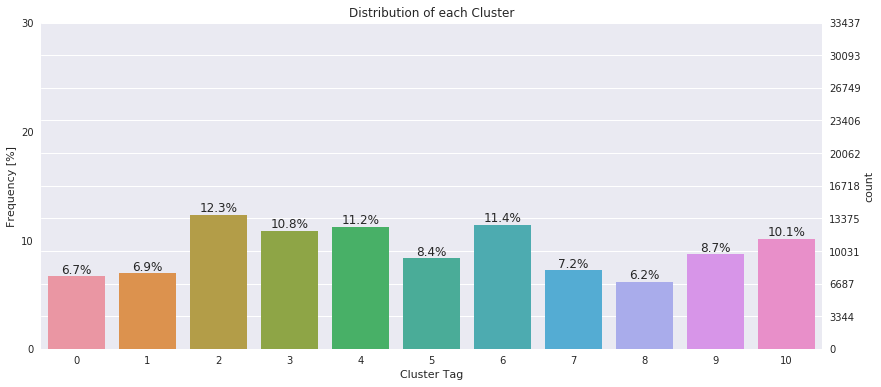

In [113]:
df_prediction_azdias = pd.DataFrame(predict_general_clusters, columns = ['Cluster'])
plot_distribution(df_prediction_azdias, 'Cluster', height = 30)

In [114]:
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [115]:
customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)

In [116]:
customers.shape

(191652, 366)

In [117]:
customers_cleaned = clean_data(customers)

Removal of Columns with over 20% null values complete...
Removal of undocumented columns complete...
Feature Engineering PRAEGENDE_JUGENDJAHRE complete...
Feature Engineering CAMEO_INTL_2015 complete...
Feature Engineering WOHNLAGE complete...
Finished!


In [118]:
customers_cleaned.shape

(130661, 584)

In [119]:
customers_cleaned_imputed = imputer.transform(customers_cleaned)
print('Type of customers_cleaned_imputed is : {}'.format(type(customers_cleaned_imputed)))

# Making customers_cleaned_imputed into a dataframe
customers_cleaned_imputed = pd.DataFrame(customers_cleaned_imputed)
print('Type of customers_cleaned_imputed now is : {}'.format(type(customers_cleaned_imputed)))

Type of customers_cleaned_imputed is : <class 'numpy.ndarray'>
Type of customers_cleaned_imputed now is : <class 'pandas.core.frame.DataFrame'>


In [120]:
sum(customers_cleaned_imputed.isnull().sum(axis=1))

0

In [121]:
customers_scaled = SC.transform(customers_cleaned_imputed)
print('Type of customers_scaled is : {}'.format(type(customers_scaled)))

# Making azdias_scaled into a dataframe
customers_scaled = pd.DataFrame(customers_scaled, columns= list(customers_cleaned.columns.values))
print('Type of customers_scaled now is : {}'.format(type(customers_scaled)))
customers_scaled.head()

Type of customers_scaled is : <class 'numpy.ndarray'>
Type of customers_scaled now is : <class 'pandas.core.frame.DataFrame'>


,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_REST,...,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage,WOHNLAGE_rural,WOHNLAGE_rating_class
0,-0.455146,-0.120275,0.074233,-0.060474,-2.135091,-0.533123,-0.548790,-0.420061,-0.155596,-0.338543,...,1.415928,-0.602032,-0.32662,-0.28788,-1.544694,-1.701836,-1.474411,0.025025,1.76719,-1.448974
1,-0.455146,-0.120275,-0.752060,-0.060474,-0.144504,1.307993,-0.548790,-0.420061,-0.155596,-0.338543,...,1.415928,-0.602032,-0.32662,-0.28788,-1.544694,-1.701836,-0.113985,0.705305,-0.56587,-0.212914
2,-0.455146,-0.120275,-1.578353,-0.060474,-2.135091,1.307993,-0.548790,-0.420061,-0.155596,-0.338543,...,-0.706250,-0.602032,-0.32662,-0.28788,-2.212287,0.587601,-0.794198,0.705305,1.76719,-1.448974
3,-0.033783,-0.120275,1.726818,-0.060474,-0.144504,-0.533123,1.634835,-0.420061,3.020810,-0.338543,...,-0.706250,-0.602032,-0.32662,-0.28788,-0.209509,0.587601,0.566228,-1.335537,-0.56587,0.405117
4,-0.455146,-0.120275,0.074233,-0.060474,-0.144504,1.307993,-0.548790,-0.420061,-0.155596,-0.338543,...,-0.706250,-0.602032,-0.32662,-0.28788,-1.544694,-1.701836,-0.113985,0.705305,-0.56587,-0.830944


In [122]:
customers_pca = pca_82.transform(customers_scaled)

In [123]:
customers_pca.shape

(130661, 82)

In [124]:
predict_customers_clusters = model_general.predict(customers_pca)

In [125]:
def display_component_labels(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = 82-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)
    print("Cluster: ",component_num, sorted_weight_data)
    return sorted_weight_data

In [126]:
for num in range(0,11):
    display_component_labels(pd.DataFrame(pca_82.components_), azdias_sample_scaled.columns, num, n_weights=10)

Cluster:  0      weights            features  abs_weights
41 -0.232552    D19_VERSI_ANZ_24     0.232552
12  0.176336         D19_BILDUNG     0.176336
58  0.117089        KBA05_ALTER2     0.117089
21 -0.101692       D19_HAUS_DEKO     0.101692
76  0.101475        KBA05_HERST3     0.101475
42  0.100347  D19_VERSICHERUNGEN     0.100347
51 -0.098394    FINANZ_VORSORGER     0.098394
45 -0.092708            EWDICHTE     0.092708
52  0.084561  GEBAEUDETYP_RASTER     0.084561
46  0.082466      FINANZ_ANLEGER     0.082466
Cluster:  1      weights            features  abs_weights
27 -0.133457          D19_REISEN     0.133457
21  0.113404       D19_HAUS_DEKO     0.113404
7  -0.100918    D19_BANKEN_GROSS     0.100918
9   0.094934     D19_BANKEN_REST     0.094934
6   0.092558   D19_BANKEN_DIREKT     0.092558
80 -0.074660      KBA05_KRSAQUOT     0.074660
15 -0.073190      D19_DIGIT_SERV     0.073190
10 -0.072879  D19_BEKLEIDUNG_GEH     0.072879
37 -0.063174  D19_VERSAND_ANZ_12     0.063174
1   0.0600

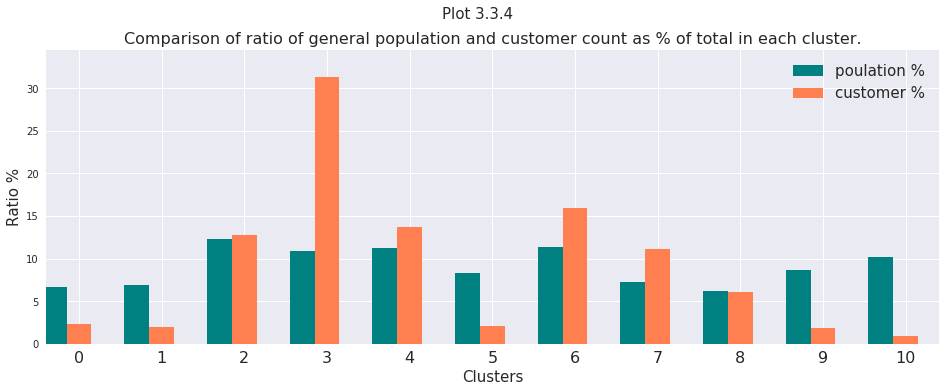

In [127]:
customers_clusters = pd.Series(predict_customers_clusters)
count_cc = customers_clusters.value_counts().sort_index()
population_clusters = pd.Series(predict_general_clusters)
count_pc = population_clusters.value_counts().sort_index()
pop_cust_clusters_data_count_df = pd.concat([count_pc, count_cc], axis=1).reset_index()
pop_cust_clusters_data_count_df.columns = ['cluster', 'population', 'customer']
pop_cust_clusters_data_count_df['pop_%'] = (pop_cust_clusters_data_count_df['population']\
                                            /pop_cust_clusters_data_count_df['population'].sum()*100).round(2)
pop_cust_clusters_data_count_df['cust_%'] = (pop_cust_clusters_data_count_df['customer']\
                                             /pop_cust_clusters_data_count_df['customer'].sum()*100).round(2)
pop_cust_clusters_data_count_df['diff'] = pop_cust_clusters_data_count_df['cust_%'] - pop_cust_clusters_data_count_df['pop_%']

fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(111)

ax = pop_cust_clusters_data_count_df['pop_%'].plot(x=pop_cust_clusters_data_count_df['cluster'], kind='bar',\
                                                   color='teal',width=-0.3, align='edge',position=0)
ax = pop_cust_clusters_data_count_df['cust_%'].plot(x=pop_cust_clusters_data_count_df['cluster'], kind='bar',\
                                                    color='coral',width = 0.3, align='edge',position=1)

ax.margins(x=0.5,y=0.1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Ratio %', fontsize=15)
ax.xaxis.set(ticklabels= pop_cust_clusters_data_count_df['cluster'])
ax.tick_params(axis = 'x', which = 'major', labelsize = 16)
plt.xticks(rotation=360,)

plt.legend(('poulation %', 'customer %'),fontsize=15)
plt.title(('Comparison of ratio of general population and customer count as % of total in each cluster.')
          ,fontsize=16)

plt.subplots_adjust(bottom=0.2)
plt.suptitle("Plot 3.3.4", fontsize=15)
plt.show()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [128]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [129]:
mailout_train.shape

(42962, 367)

In [130]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [131]:
def find_cols_missing_pct_data(df, pct):
    '''
    INPUT:
        df - (dataframe), dataframe to check for missing values in its columns
    OUTPUT:
        missing_pct_cols: (list), list of columns with more than pct missing values
    '''
    missing_pct_cols = [col for col in df.columns if (df[col].isnull().sum()/df.shape[0]) * 100 > pct]
    return missing_pct_cols

In [132]:
train_features = mailout_train.drop(['RESPONSE'], axis=1)
train_response = mailout_train['RESPONSE']

In [133]:
# Revise clean_data function to preserve all the rows to predict
def clean_data_revised(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned DataFrame
    """
    for idx in data_types.index:
        column = idx
        if column in df.columns:
            df[column] = df[column].replace(data_types.loc[column]['nan_vals'], np.nan)

    # Find the name of columns with more than 25% missing values
    missing_25 = find_cols_missing_pct_data(df, pct=25)
    
    # remove selected columns(columns having missing values more than 25%)
    df.drop(missing_25, axis=1, inplace=True)
    
    # drop column 'LNR' as it contains unique ID for each individual
    df.drop('LNR', axis=1, inplace=True)
    
    # select, re-encode, and engineer few features
    df['PRAEGENDE_JUGENDJAHRE_decade'] = df['PRAEGENDE_JUGENDJAHRE'].apply(make_decade)
    df['PRAEGENDE_JUGENDJAHRE_movement'] = df['PRAEGENDE_JUGENDJAHRE'].apply(make_movement)
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    df['WOHNLAGE_rural'] = df['WOHNLAGE'].map({0:0,1:0,2:0,3:0,4:0,5:0,7:1,8:1})
    df['WOHNLAGE_rating_class'] = df['WOHNLAGE'].map({0:0,1:1,2:2,3:3,4:4,5:5,7:0,8:0})
    
    df = df.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'], axis=1)
    
    # Taking care of 6 features with dtype as 'Object'
    # 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM' & 'OST_WEST_KZ'
    df['OST_WEST_KZ'].replace(['W','O'], [1, 0], inplace=True)
    
    df['CAMEO_INTL_2015_wealth'] = df['CAMEO_INTL_2015'].apply(make_wealth) 
    df['CAMEO_INTL_2015_life_stage'] = df['CAMEO_INTL_2015'].apply(make_life_stage)
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype('float64')
    
    df = df.drop(['EINGEFUEGT_AM'], axis=1) # drop feature 'EINGEFUEGT_AM' as it contains unique timestamp
    
    multi = ['CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE']
    df = pd.get_dummies(df, columns=multi, prefix=multi, dummy_na=True, drop_first=True)

    # Return the cleaned dataframe.
    return df

In [134]:
train_features_cleaned = clean_data_revised(train_features)

In [135]:
train_features_cleaned.shape

(42962, 430)

In [136]:

# Impute nans with median value
imputer = Imputer(missing_values='NaN',strategy='median',axis=0)
train_features_imputed = imputer.fit_transform(train_features_cleaned)
print('Type of train_features_imputed is : {}'.format(type(train_features_imputed)))

# Making train_features_imputed into a dataframe
train_features_imputed = pd.DataFrame(train_features_imputed)
print('Type of train_features_imputed now is : {}'.format(type(train_features_imputed)))
train_features_imputed.head()


Type of train_features_imputed is : <class 'numpy.ndarray'>
Type of train_features_imputed now is : <class 'pandas.core.frame.DataFrame'>


,0,1,2,3,4,5,6,7,8,9,...,420,421,422,423,424,425,426,427,428,429
0,1.0,8.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,5.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,4.0,13.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,5.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,7.0,2.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,6.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,9.0,53.0,0.0,0.0,1.0,44.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [137]:
sum(train_features_imputed.isnull().sum())

0

In [138]:
 #Apply feature scaling to the train_features_imputed dataset.

scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features_imputed)
print('Type of train_features_scaled is : {}'.format(type(train_features_scaled)))

# Making train_features_scaled into a dataframe
train_features_scaled = pd.DataFrame(train_features_scaled, columns= list(train_features_cleaned.columns.values))
print('Type of train_features_scaled now is : {}'.format(type(train_features_scaled)))
train_features_scaled.head()


Type of train_features_scaled is : <class 'numpy.ndarray'>
Type of train_features_scaled now is : <class 'pandas.core.frame.DataFrame'>


,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,D19_LETZTER_KAUF_BRANCHE_nan
0,-0.274048,-0.478176,0.659884,-0.116979,-0.204857,-0.815974,0.573741,-0.083831,-0.038459,0.303152,...,-0.094717,-0.113246,-0.112718,-0.052032,1.783482,-0.138797,-0.257011,-0.23723,-0.085392,-0.463002
1,1.594293,0.791833,-0.352970,-0.116979,-0.204857,-0.011516,-0.344470,-0.083831,-1.110675,0.303152,...,-0.094717,8.830304,-0.112718,-0.052032,-0.560701,-0.138797,-0.257011,-0.23723,-0.085392,-0.463002
2,-0.274048,-0.732178,-0.280624,-0.116979,-0.204857,-1.620432,-0.344470,-0.083831,1.033757,-1.690267,...,-0.094717,-0.113246,-0.112718,-0.052032,-0.560701,-0.138797,-0.257011,-0.23723,-0.085392,-0.463002
3,-0.274048,-0.986180,-0.135930,-0.116979,-0.204857,-0.011516,-0.114917,-0.083831,1.033757,-1.191912,...,-0.094717,-0.113246,-0.112718,-0.052032,1.783482,-0.138797,-0.257011,-0.23723,-0.085392,-0.463002
4,-0.274048,-0.224175,3.409061,-0.116979,-0.204857,-0.815974,2.945784,-0.083831,-0.038459,-0.195203,...,-0.094717,-0.113246,-0.112718,-0.052032,-0.560701,-0.138797,-0.257011,-0.23723,-0.085392,-0.463002


In [139]:
import time
# Define fit_classifier function to fit different classifiers on training dataset i.e. train_features_scaled
# to find the best performing classifier algorithm
def fit_classifier(clf, param_grid, X=train_features_scaled, y=train_response):
    """
    Fits a classifier to its training data using GridSearchCV and calculates ROC AUC score
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    
    # cv uses StratifiedKFold
    # scoring roc_auc available as parameter
    start = time.time()
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=0)
    print("Training {} :".format(clf.__class__.__name__))
    grid.fit(X, y)
    end = time.time()
    time_taken = round(end-start,2)

    print(clf.__class__.__name__)
    print("Time taken : {} secs".format(time_taken))
    print("Best score : {}".format(round(grid.best_score_,4)))
    print("*"*40)
    
    return grid.best_score_, grid.best_estimator_, time_taken


In [140]:
lor = LogisticRegression(random_state=42) # LogisticRegression
rfc = RandomForestClassifier(random_state=42) # RandomForestClassifier
abc = AdaBoostClassifier(random_state=42) # AdaBoostClassifier
gbc = GradientBoostingClassifier(random_state=42) # GradientBoostingClassifier
lsvc = LinearSVC(random_state=42) #LinearSupportVectorClassifier
lgbm = lgb.LGBMRegressor(random_state=42)
xgb = XGBClassifier(random_state=42)
gnb = GaussianNB() 
bnb = BernoulliNB()
lgbmc = lgb.LGBMClassifier(random_state=42)

In [141]:
# Find best classification algorithm
clf_names = []
clf_scores = []
clf_best_ests = []
clf_time_taken = []
clf_dict = {}

for clf in [xgb,lgbmc,gnb,bnb,lgbm,lsvc,lor, rfc, abc, gbc]:
    best_score, best_est, time_taken = fit_classifier(clf, {})
    clf_names.append(clf.__class__.__name__)
    clf_scores.append(best_score)
    clf_best_ests.append(best_est)
    clf_time_taken.append(time_taken)

Training XGBClassifier :
XGBClassifier
Time taken : 275.22 secs
Best score : 0.7587
****************************************
Training LGBMClassifier :
LGBMClassifier
Time taken : 89.87 secs
Best score : 0.704
****************************************
Training GaussianNB :
GaussianNB
Time taken : 6.79 secs
Best score : 0.5253
****************************************
Training BernoulliNB :
BernoulliNB
Time taken : 7.17 secs
Best score : 0.6202
****************************************
Training LGBMRegressor :
LGBMRegressor
Time taken : 70.99 secs
Best score : 0.6632
****************************************
Training LinearSVC :
LinearSVC
Time taken : 693.44 secs
Best score : 0.5982
****************************************
Training LogisticRegression :
LogisticRegression
Time taken : 156.05 secs
Best score : 0.6514
****************************************
Training RandomForestClassifier :
RandomForestClassifier
Time taken : 11.54 secs
Best score : 0.5095
*************************************

In [ ]:
1

In [143]:
clf_dict['best_score'] = clf_scores
clf_dict['time_taken'] = clf_time_taken
clf_dict['best_est'] = clf_best_ests
clf_df = pd.DataFrame(clf_dict, index=clf_names)
clf_df

,best_score,time_taken,best_est
XGBClassifier,0.758731,275.22,"XGBClassifier(base_score=0.5, booster='gbtree'..."
LGBMClassifier,0.704013,89.87,"LGBMClassifier(boosting_type='gbdt', class_wei..."
GaussianNB,0.525332,6.79,GaussianNB(priors=None)
BernoulliNB,0.620234,7.17,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri..."
LGBMRegressor,0.663249,70.99,"LGBMRegressor(boosting_type='gbdt', class_weig..."
LinearSVC,0.598187,693.44,"LinearSVC(C=1.0, class_weight=None, dual=True,..."
LogisticRegression,0.651423,156.05,"LogisticRegression(C=1.0, class_weight=None, d..."
RandomForestClassifier,0.509507,11.54,"(DecisionTreeClassifier(class_weight=None, cri..."
AdaBoostClassifier,0.723684,107.90,"(DecisionTreeClassifier(class_weight=None, cri..."
GradientBoostingClassifier,0.749907,354.47,([DecisionTreeRegressor(criterion='friedman_ms...


In [144]:
clf_df.loc['GradientBoostingClassifier', 'best_est']

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [211]:
# Tune the best classifier with the help of param grid in GridSearchCV
# The fine tuned model will be used with the test set
param_grid = {#'loss': ['deviance', 'exponential'],
              'loss': ['exponential'],
              'learning_rate': [0.01],
              'n_estimators': [900],
              'max_depth': [4],
              'min_child_weight':[6],
              'gamma':[0],
              'subsample':[0.8],
              'colsample_bytree':[0.8],
              'reg_alpha':[0.005],
              'nthread':[4],
              'scale_pos_weight':[1],
              'seed':[27]
             }


xgb_best_score, xgb_best_est, _ = fit_classifier(xgb, param_grid)
xgb_best_est

Training XGBClassifier :
XGBClassifier
Time taken : 2816.67 secs
Best score : 0.7681
****************************************


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.01, loss='exponential', max_delta_step=0,
       max_depth=4, min_child_weight=6, missing=None, n_estimators=900,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=42,
       reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, seed=27,
       silent=None, subsample=0.8, verbosity=1)

In [218]:
1

1

In [197]:
import pickle
with open("model.pkl", "wb") as f:
        pickle.dump(xgb_best_est, f)

In [219]:
# Print the most important features of the model
imp_feat = pd.DataFrame({'imp_feat':xgb_best_est.feature_importances_}, index=train_features_scaled.columns)
imp_feat_sorted = imp_feat.sort_values(by=['imp_feat'], ascending=False)
imp_feat_sorted.head(10)

,imp_feat
D19_SOZIALES,0.007881
KBA05_SEG4,0.005781
FINANZ_SPARER,0.005572
KBA05_CCM3,0.005346
PLZ8_ANTG4,0.005313
D19_LETZTER_KAUF_BRANCHE_nan,0.005294
FINANZ_VORSORGER,0.005150
KBA13_TOYOTA,0.004946
KBA13_ANTG1,0.004868
D19_KONSUMTYP_MAX,0.004725


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [220]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [221]:
test_LNR = mailout_test['LNR']

In [222]:
test_cleaned = clean_data_revised(mailout_test)

In [223]:
test_imputed = pd.DataFrame(imputer.transform(test_cleaned))
test_scaled = pd.DataFrame(scaler.transform(test_imputed), columns= list(test_cleaned.columns.values))

In [224]:
test_response = xgb_best_est.predict(test_scaled)

In [225]:
test_response

array([0, 0, 0, ..., 0, 0, 0])

In [226]:
xgb_best_est.classes_

array([0, 1])

In [227]:
test_response_proba = xgb_best_est.predict_proba(test_scaled)
test_response_proba

array([[ 0.9605633 ,  0.03943669],
       [ 0.97411209,  0.02588792],
       [ 0.99631041,  0.0036896 ],
       ..., 
       [ 0.97307384,  0.02692614],
       [ 0.97771215,  0.02228785],
       [ 0.98235476,  0.01764526]], dtype=float32)

In [228]:
 test_response_proba[:, 1]

array([ 0.03943669,  0.02588792,  0.0036896 , ...,  0.02692614,
        0.02228785,  0.01764526], dtype=float32)

In [229]:
kaggle_df = pd.DataFrame({'LNR': test_LNR, 'RESPONSE':  test_response_proba[:, 1]})
kaggle_df.head()

,LNR,RESPONSE
0,1754,0.039437
1,1770,0.025888
2,1465,0.003690
3,1470,0.003681
4,1478,0.005072


In [230]:
kaggle_df.to_csv('kaggle_submission_file_three.csv', index=False)